## Off-target frequency simulations with no on-target spots

In [1]:
import numpy as np
import pandas as pd
import pyro
import torch
import matplotlib.pyplot as plt
from collections import defaultdict
from matplotlib.ticker import FormatStrFormatter
from pathlib import Path
from pyro.ops.stats import hpdi, quantile
from pyro.infer import Predictive
import pyro.distributions as dist

from tapqir.models import Cosmos
from tapqir.utils.stats import ci_from_trace

### Load results

In [8]:
EXAMLES_DIR = Path.cwd().resolve().parent.parent.parent / "examples" / "data"

In [9]:
D = 14
background = 150
gain = torch.tensor(7.)
width = torch.tensor([1.4])
rv = dist.MultivariateNormal(
    torch.tensor([(D-1)/2, (D-1)/2]),
    scale_tril=torch.eye(2) * width[..., None, None])

D_range = torch.arange(D, dtype=torch.float)
i_pixel, j_pixel = torch.meshgrid(D_range, D_range)
ij_pixel = torch.stack((i_pixel, j_pixel), dim=-1)

In [11]:
truth = {}
fit = {}
predictions = defaultdict(dict)
models = {}
for data_path in EXAMLES_DIR.iterdir():
    if data_path.is_dir() and data_path.name.startswith("negative"):
        # load results
        truth[data_path.name] = pd.read_csv(
            data_path / "simulated_params.csv",
            squeeze=True, index_col=0
        ).rename(data_path.name)
        
        param_path = data_path / "runs/cosmos/v1.1.6/S1/control/lr0.005/bs4/"
        
        fit[data_path.name] = pd.read_csv(
            param_path / "global_params.csv",
            squeeze=True,
            index_col=0
        ).rename(data_path.name)
        fit[data_path.name]["lamda"] = truth[data_path.name]["lamda"]
        
        models[data_path.name] = Cosmos()
        models[data_path.name].load(data_path, True, "cpu")
        models[data_path.name].load_parameters(param_path)
        
        # calculate ci
        mask = torch.from_numpy(models[data_path.name].data.labels["z"])
        samples = torch.masked_select(models[data_path.name].z_marginal, mask)
        predictions[data_path.name]["z_masked"] = samples
        predictions[data_path.name]["z_all"] = models[data_path.name].z_marginal.flatten()
        
        tr = pyro.poutine.trace(models[data_path.name].guide).get_trace()
        global_params = ["gain", "pi", "lamda", "proximity"]
        ci_stats = ci_from_trace(tr, global_params)
        
        for param in global_params:
            if param == "pi":
                fit[data_path.name][f"{param}_mean"] = ci_stats[param]["mean"][1].item()
                fit[data_path.name][f"{param}_low"] = ci_stats[param]["low"][1].item()
                fit[data_path.name][f"{param}_high"] = ci_stats[param]["high"][1].item()
            else:
                fit[data_path.name][f"{param}_mean"] = ci_stats[param]["mean"]
                fit[data_path.name][f"{param}_low"] = ci_stats[param]["low"]
                fit[data_path.name][f"{param}_high"] = ci_stats[param]["high"]
        fit[data_path.name]["height"] = truth[data_path.name]["height"]
        #fit[data_path.name]["seed"] = int(data_path.name[4:])
        
        # snr
        weights = rv.log_prob(ij_pixel).exp()
        signal = (weights ** 2 * truth[data_path.name]["height"]).sum()
        noise = np.sqrt((truth[data_path.name]["background"] * truth[data_path.name]["gain"]))
        truth[data_path.name]["snr"] = float(signal / noise)
        fit[data_path.name]["snr"] = models[data_path.name].snr().mean().item()

In [12]:
truth_df = pd.concat(truth.values(), axis=1).T
truth_df = truth_df.sort_values(by="lamda")
truth_df

,gain,pi,lamda,proximity,offset,height,background,snr
negative0.01,7.0,0.0,0.01,0.2,90.0,3000.0,150.0,3.7589
negative0.05,7.0,0.0,0.05,0.2,90.0,3000.0,150.0,3.7589
negative0.15,7.0,0.0,0.15,0.2,90.0,3000.0,150.0,3.7589
negative0.5,7.0,0.0,0.50,0.2,90.0,3000.0,150.0,3.7589
negative1,7.0,0.0,1.00,0.2,90.0,3000.0,150.0,3.7589


In [13]:
fit_df = pd.concat(fit.values(), axis=1).T.sort_values(by="lamda")
fit_df.style.format("{:.3f}")

,-ELBO,proximity_loc,proximity_beta,gain_loc,gain_beta,pi_mean_0,pi_mean_1,pi_size,lamda_loc,lamda_beta,lamda,gain_mean,gain_low,gain_high,pi_mean,pi_low,pi_high,lamda_mean,lamda_low,lamda_high,proximity_mean,proximity_low,proximity_high,height,snr
negative0.01,4785917.500,1.646,1.098,7.000,17280.314,0.999,0.001,595.581,0.011,5284.139,0.010,7.000,6.958,7.038,0.001,0.000,0.004,0.011,0.008,0.014,1.646,0.187,4.873,3000.000,3.613
negative0.05,4789930.000,1.367,1.317,7.010,29457.188,0.999,0.001,673.722,0.050,5045.432,0.050,7.010,6.977,7.041,0.001,0.000,0.004,0.050,0.044,0.056,1.367,0.112,3.949,3000.000,3.534
negative0.15,4798066.500,1.310,1.625,7.003,69110.578,0.999,0.001,595.877,0.140,5923.985,0.150,7.003,6.982,7.021,0.001,0.000,0.005,0.140,0.131,0.151,1.310,0.151,3.555,3000.000,3.535
negative0.5,4829183.500,1.455,1.798,7.012,71506.297,0.999,0.001,398.358,0.490,6347.422,0.500,7.012,6.993,7.032,0.001,0.000,0.007,0.490,0.472,0.507,1.455,0.264,3.534,3000.000,3.529
negative1,4868056.500,1.240,1.286,7.093,48784.082,0.999,0.001,564.295,0.951,5435.144,1.000,7.093,7.069,7.115,0.001,0.000,0.004,0.951,0.927,0.978,1.240,0.149,3.493,3000.000,3.575


### Figure 4

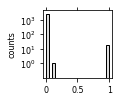

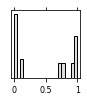

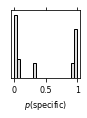

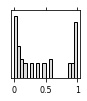

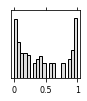

In [15]:
for name in fit_df.index:
    fig, ax = plt.subplots(figsize=(1.25, 1.25))
    ax.hist(predictions[name]["z_all"].numpy(),
             bins=np.arange(0, 1.05, 0.05), histtype="bar", lw=1.,
             color="#dddddd", edgecolor="k",
             label=f"{truth_df.loc[name, 'snr']:.2f} SNR")
    ax.hist(predictions[name]["z_masked"].numpy(),
             bins=np.arange(0, 1.05, 0.05), histtype="bar", lw=1.,
             color="C2", edgecolor="k",
             label=f"{truth_df.loc[name, 'snr']:.2f} SNR")
    ax.set_yscale("log")
    ax.set_xlim(-0.05,1.05)
    ax.set_ylim(1e-1, 5e3)
    ax.set_xticks([0, 0.5, 1])
    ax.tick_params(axis="x", labelsize=8, top=True)
    
    if name == "negative0.01":
        ax.set_ylabel("counts", fontsize=8)
        ax.set_yticks([1, 10, 100, 1000])
        ax.tick_params(axis="y", labelsize=8)
    else:
        ax.set_yticks([])
        ax.tick_params(axis="y", labelsize=8)
    if name == "negative0.15":
        ax.set_xlabel(r"$p(\mathsf{specific})$", fontsize=8)
    ax.xaxis.set_major_formatter(FormatStrFormatter('%g'))
    # plt.legend(loc="upper center", fontsize=8)
    plt.savefig(f"/tmp/logdensity-{name}.svg")
    plt.show()

### Analysis

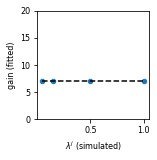

In [8]:
plt.figure(figsize=(2, 2))
plt.plot(truth_df["rate_j"].sort_values(), truth_df["gain"].sort_values(), "k--")
plt.scatter(truth_df["rate_j"], fit_df["gain"], s=20)
plt.ylim(0, 20)
plt.xticks(fontsize=8)
plt.yticks(fontsize=8)
plt.xlabel(r"$\lambda^j$ (simulated)", fontsize=8)
plt.ylabel("gain (fitted)", fontsize=8)
plt.show()

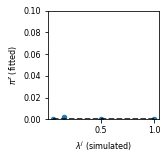

In [9]:
plt.figure(figsize=(2, 2))
plt.plot(truth_df["rate_j"].sort_values(), truth_df["probs_z"].sort_values(), "k--")
plt.scatter(truth_df["rate_j"], fit_df["probs_z_1"], s=20)
plt.ylim(0, 0.1)
plt.xticks(fontsize=8)
plt.yticks(fontsize=8)
plt.xlabel(r"$\lambda^j$ (simulated)", fontsize=8)
plt.ylabel(r"$\pi^z$ (fitted)", fontsize=8)
plt.show()

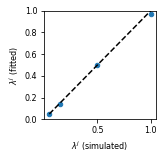

In [10]:
plt.figure(figsize=(2, 2))
plt.plot(truth_df["rate_j"].sort_values(), truth_df["rate_j"].sort_values(), "k--")
plt.scatter(truth_df["rate_j"], fit_df["rate_j"], s=20)
plt.ylim(0, 1.)
plt.xticks(fontsize=8)
plt.yticks(fontsize=8)
plt.xlabel(r"$\lambda^j$ (simulated)", fontsize=8)
plt.ylabel(r"$\lambda^j$ (fitted)", fontsize=8)
plt.show()

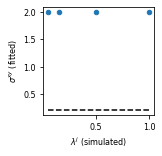

In [11]:
plt.figure(figsize=(2, 2))
plt.plot(truth_df["rate_j"].sort_values(), truth_df["proximity"].sort_values(), "k--")
plt.scatter(truth_df["rate_j"], fit_df["proximity_0"], s=20)
# plt.ylim(0., 0.6)
plt.xticks(fontsize=8)
plt.yticks(fontsize=8)
plt.xlabel(r"$\lambda^j$ (simulated)", fontsize=8)
plt.ylabel(r"$\sigma^{xy}$ (fitted)", fontsize=8)
plt.show()